# Parameters

In [1]:
uns_parameter_percentage = 1.0
model_parameter_name = 'cbm'
gpu_id = '3'

# Imports

In [2]:
import re
import sys
import os
import torch
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import setproctitle, socket, uuid

from tqdm import tqdm

from argparse import Namespace
from sklearn.metrics import confusion_matrix
from warmup_scheduler import GradualWarmupScheduler

from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import Module

os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
sys.path.append(os.path.abspath(".."))       # for 'protonet_mnist_add_utils' folder
sys.path.append(os.path.abspath("../.."))    # for 'data' folder
sys.path.append(os.path.abspath("../../..")) # for 'models' and 'datasets' folders

print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort']


In [3]:
from models import get_model
from models.mnistdpl import MnistDPL

from datasets import get_dataset

from utils import fprint
from utils.checkpoint import save_model
from utils.status import progress_bar
from utils.dpl_loss import ADDMNIST_DPL
from utils.metrics import evaluate_metrics
from utils.train import convert_to_categories, compute_coverage

from backbones.addmnist_protonet import PrototypicalLoss

from protonet_mnist_add_modules.utility_modules import sanity_checker
from protonet_mnist_add_modules.data_modules import my_datasets
from protonet_mnist_add_modules.data_modules.proto_data_creation import (
    choose_initial_prototypes, 
    get_augmented_support_query_set, 
    get_augmented_support_query_loader
)
from protonet_mnist_add_modules.utility_modules.proto_utils import (
    init_dataloader, 
    get_random_classes
)
from protonet_mnist_add_modules.data_modules.prototypical_batch_sampler import PrototypicalBatchSampler
from protonet_mnist_add_modules.utility_modules.plotting import plot_episodic_dataloader

#from protonet_mnist_math_modules.arguments import args_dpl, args_cbm

In [4]:
args_cbm = Namespace(
    and_op='Godel',
    backbone='conceptizer', 
    batch_size=64, # & ok          
    beta=0.99,                      
    boia_model='ce', 
    boia_ood_knowledge=False, 
    c_sup=0.05, 
    c_sup_ltn=0, 
    checkin=None, 
    checkout=False, 
    count=30, 
    dataset='mnmath',     
    entity='', 
    entropy=False, 
    exp_decay=0.9,                  
    gamma=1e-3,                      
    imp_op='Prod',
    joint=False, 
    lr=0.001,  # & ok                     
    model='promnmathcbm',   # ^ 'mnmathcbm' for CBM model and 'promnmathdpl' for DPL + PNet          
    n_epochs=40,
    non_verbose=False, 
    notes=None, 
    or_op='Prod',           
    p=6,                    
    posthoc=False, 
    preprocess=False, 
    proj_name='', 
    project='Reasoning-Shortcuts', 
    seeds=[], 
    splitted=False, 
    task='mnmath', 
    tuning=False, 
    use_ood=False, 
    val_metric='accuracy', 
    validate=False, 
    w_c=1, 
    w_h=0,                       
    w_rec=1, 
    w_sl=10,
    wandb=None, 
    warmup_steps=0, 
    weight_decay=0.0001,  # & ok          
    which_c=[9],
    device=torch.device("cuda"),
    
    seed = 1415,        # 1415, 1617, 1819, || 2021, 2223.
    patience = 15,
    prototypes=True,
    prototypical_dataset='addmnist', # ^ dataset with complete digits to create support and query set
    prototypical_batch_size=32,
    n_support=75,
    embedding_dim=64,
    debug=False,
    proto_lr=0.001,
    proto_epochs=10,
    hide=[],

    num_support = 5,                         # ✅ Episodic training
    num_query = 5,                           # ✅ Episodic training
    num_samples = 10,                        # ✅ Episodic training (num_support + num_query
    classes_per_it = 5,                      # ✅ Episodic training
    iterations = 100,                        # ✅ Episodic training

    no_interaction = False,
)

# Setup

In [5]:
if model_parameter_name == 'dpl':
    args = args_dpl
else:
    args = args_cbm

# logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()

# set job name
setproctitle.setproctitle(
    "{}_{}_{}".format(
        args.model,
        args.buffer_size if "buffer_size" in args else 0,
        args.dataset,
    )
)

# saving
save_folder = "mnmath" 
save_model_name = model_parameter_name

save_path = os.path.join("..",
    "notebook-outputs", 
    save_folder, 
    "my_models", 
    save_model_name,
    f"episodic-proto-net-pipeline-{uns_parameter_percentage}"
)
print(f"Save paths: {str(save_path)}")

if args.model in ['mnmathdpl', 'mnmathcbm'] or not args.prototypes:
    raise ValueError("This experiment is not meant for baseline models.")

Save paths: ../notebook-outputs/mnmath/my_models/cbm/episodic-proto-net-pipeline-1.0


# Utilities

Plots the first *n* images from a batch, with their labels and concept annotations.

In [6]:
def plot_images(images, labels, concepts, n=3):
    """
    Args:
        images (torch.Tensor): Shape [B, 1, 28, 224] - batch of concatenated MNIST digits.
        labels (torch.Tensor): Shape [B, 2] - two binary labels per image.
        concepts (torch.Tensor): Shape [B, 2, 4] - concept annotations per digit.
    """
    fig, axs = plt.subplots(1, n, figsize=(12, 5))

    for i in range(n):
        img = images[i].squeeze(0)  # Shape [28, 224]
        lbl = labels[i].tolist()
        cpt = concepts[i].tolist()

        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        
        axs[i].set_title(f"Labels: {lbl}", fontsize=10)
        axs[i].text(0.5, -0.1,
                    f"Concepts: {cpt}",
                    fontsize=8,
                    ha='center',
                    va='top',
                    transform=axs[i].transAxes)

    plt.tight_layout()
    plt.show()

Returns the support and query loaders for the prototypical network training

In [7]:
def create_support_query_sets_and_loaders(args):
    args_protonet = Namespace(
        dataset=args.prototypical_dataset,     
        batch_size=args.prototypical_batch_size,
        preprocess=0,
        c_sup=1,    # ^ supervision loaded to simulate direct annotation for prototypes
        which_c=[-1],
        model=args.model,        
        task=args.task,    
    )
    addmnist_dataset = get_dataset(args_protonet)
    addmnist_train_loader, _ , _ = addmnist_dataset.get_data_loaders()

    if ( (not os.path.exists('data/prototypes/proto_loader_dataset.pth')) or args.debug ):
        print("Creating initial prototypes...")
        choose_initial_prototypes(addmnist_train_loader, debug=args.debug)

    tr_dataloader = init_dataloader()
    support_images_aug, support_labels_aug, query_images_aug, query_labels_aug, no_aug = get_augmented_support_query_set(
        tr_dataloader, debug=args.debug)
    support_loader, query_loader = get_augmented_support_query_loader(
        support_images_aug, 
        support_labels_aug, 
        query_images_aug, 
        query_labels_aug,
        query_batch_size=32,
        debug=args.debug
    )

    return support_loader, support_images_aug, support_labels_aug, query_loader, no_aug

# Data Loading

## Load Annotated Prototypes

run all things about protonets

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Loading train data
Loading val data
Loading test data
Number of rotations:  400
Number of translations:  1440
Number of scalings:  100
Number of elastic transformations:  250
Number of noising transformations:  40
Number of distinct labels: 10
Classes in dataset: [0 1 2 3 4 5 6 7 8 9]
Batch images shape: torch.Size([50, 1, 28, 28])
Batch labels: [0, 3, 5, 0, 0, 9, 9, 3, 0, 3, 0, 9, 5, 6, 9, 3, 3, 9, 6, 6, 6, 9, 0, 5, 0, 0, 9, 0, 3, 6, 6, 6, 3, 3, 5, 5, 0, 3, 5, 5, 9, 5, 6, 6, 3, 9, 9, 6, 5, 5]
Label distribution in batch: Counter({0: 10, 3: 10, 5: 10, 9: 10, 6: 10})


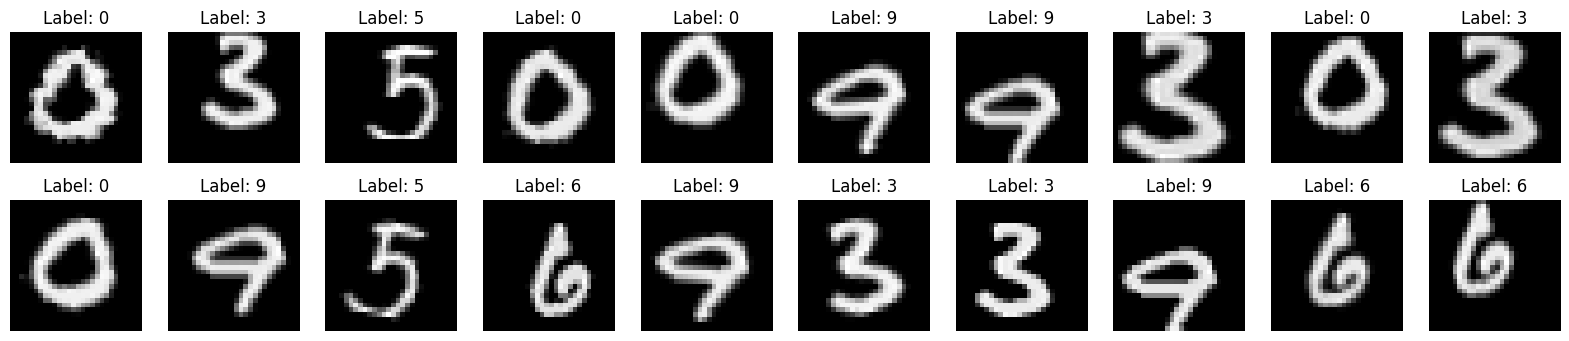

In [8]:
support_loader, support_images_aug, support_labels_aug, query_loader, _ = create_support_query_sets_and_loaders(args)
mnist_dataset = my_datasets.MNISTAugDataset(support_images_aug, support_labels_aug, hide_labels=args.hide)
sanity_checker.assert_my_labels(args, support_labels_aug, mnist_dataset)
proto_labels = mnist_dataset.labels.squeeze().numpy()
episodic_dataloader = DataLoader(my_datasets.EmptyDataset(), batch_size=1)
if args.classes_per_it > 0:
    sampler = PrototypicalBatchSampler(proto_labels, args.classes_per_it, args.num_samples, args.iterations)
    episodic_dataloader = DataLoader(mnist_dataset, batch_sampler=sampler)
plot_episodic_dataloader(episodic_dataloader, args.num_support, args.num_query, args.classes_per_it, args)

assert torch.equal(torch.sort(torch.unique(torch.tensor(proto_labels)))[0], torch.arange(0, 10)),\
    "proto_labels must contain all values from 0 to 9"

## Unsupervised Data Import

load the unsupervised training data

In [9]:
mnmath_dataset = get_dataset(args)
mnmath_train_loader, mnmath_val_loader, mnmath_test_loader, mnmath_ood_loader = mnmath_dataset.get_data_loaders()
mnmath_dataset.print_stats()

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Loaded datasets in 0.5619585514068604 s.
Len loaders: 
 train: 1000 
 val: 200
 len test: 300
## Statistics ##
Train samples 1000
Validation samples 200
Test samples 300
Test OOD samples 300


### Unsupervised Data Inspection

*See some statistics about the dataset*

In [10]:
first_label_1 = 0
second_label_1 = 0
both_labels_1 = 0
total = 0

for data in mnmath_train_loader:
    _, labels, _ = data  # labels shape: [batch_size, 2]
    
    total += labels.size(0)
    first_label_1 += (labels[:, 0] == 1).sum().item()
    second_label_1 += (labels[:, 1] == 1).sum().item()
    both_labels_1 += ((labels[:, 0] == 1) & (labels[:, 1] == 1)).sum().item()

print(f"Total samples: {total}")
print(f"First label == 1: {first_label_1} ({100 * first_label_1 / total:.2f}%)")
print(f"Second label == 1: {second_label_1} ({100 * second_label_1 / total:.2f}%)")
print(f"Both labels == 1: {both_labels_1} ({100 * both_labels_1 / total:.2f}%)")

Total samples: 1000
First label == 1: 437 (43.70%)
Second label == 1: 125 (12.50%)
Both labels == 1: 63 (6.30%)


*Plotting some examples*

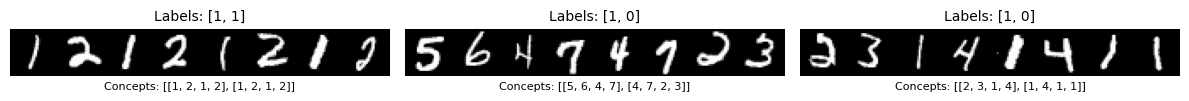

In [11]:
for data in mnmath_train_loader:
    images, labels, concepts = data  # shapes: [32, 1, 28, 224], [32, 2], [32, 2, 4]
    
    # Filter indices where either label[0] or label[1] is 1
    mask = (labels[:, 0] == 1) | (labels[:, 1] == 1)
    indices = torch.nonzero(mask).squeeze()

    if len(indices) >= 3:
        selected_images = images[indices[:3]]
        selected_labels = labels[indices[:3]]
        selected_concepts = concepts[indices[:3]]

        plot_images(selected_images, selected_labels, selected_concepts)
    else:
        print("Not enough samples with at least one positive label in this batch.")
    
    break  # only process one batch

# Creating the Model

In [12]:
n_images, c_split = mnmath_dataset.get_split()
encoder, decoder = mnmath_dataset.get_backbone()
model = get_model(args, encoder, decoder, n_images, c_split)
loss = model.get_loss(args)

print("Using Dataset: ", mnmath_dataset)
print("Using backbone: ", encoder)
print("Using Model: ", model)
print("Using Loss: ", loss)

[BACKBONE-INFO] Using Prototypical Networks as backbone
Available models: ['promnistltn', 'promnmathcbm', 'sddoiann', 'kandnn', 'sddoiadpl', 'sddoialtn', 'presddoiadpl', 'boiann', 'mnistclip', 'prokanddpl', 'promnistdpl', 'xornn', 'mnistnn', 'mnistslrec', 'kandpreprocess', 'kandsl', 'kandsloneembedding', 'prokandltn', 'kandcbm', 'prokandsl', 'boiacbm', 'kanddpl', 'kandltn', 'xorcbm', 'sddoiaclip', 'xordpl', 'promnmathdpl', 'sddoiacbm', 'mnistltnrec', 'mnmathcbm', 'mnmathdpl', 'kandclip', 'minikanddpl', 'mnistdpl', 'mnistltn', 'boiadpl', 'boialtn', 'prokandsloneembedding', 'mnistpcbmdpl', 'mnistcbm', 'probddoiadpl', 'mnistpcbmsl', 'mnistpcbmltn', 'mnistsl', 'mnistdplrec', 'cvae', 'cext', 'mnmathnn', 'promnistsl']
Using Dataset:  <datasets.mnmath.MNMATH object at 0x7f1864f41ac0>
Using backbone:  ProtoNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [13]:
model.state_dict()  # check it is non empty

OrderedDict([('encoder.encoder.0.0.weight',
              tensor([[[[-5.2731e-02, -1.5567e-01,  1.7355e-01],
                        [ 2.7088e-01,  1.5157e-01,  4.8427e-04],
                        [ 2.9357e-01, -3.7351e-02, -3.8168e-02]]],
              
              
                      [[[ 8.0817e-03,  1.2914e-01, -7.2741e-02],
                        [ 3.3290e-01, -3.7903e-02,  1.1249e-01],
                        [-2.4634e-02, -2.0828e-01, -1.0900e-01]]],
              
              
                      [[[-3.2215e-01, -1.0751e-01,  3.0119e-01],
                        [ 1.8278e-01,  2.3675e-01,  1.6090e-01],
                        [-1.6056e-01, -1.8641e-01,  2.7963e-03]]],
              
              
                      [[[-9.8933e-02,  6.0986e-02,  9.2315e-03],
                        [ 1.9049e-01, -5.0984e-02, -1.0693e-01],
                        [-3.0425e-01,  1.4584e-01,  4.3102e-02]]],
              
              
                      [[[-1.8062e-01,  2.8751e-0

# Training

## Main Loop

In [14]:
def train(model:MnistDPL,
        encoder:Module,
        episodic_dataloader:DataLoader,
        unsup_train_loader:DataLoader,
        unsup_val_loader:DataLoader,
        _loss: ADDMNIST_DPL, 
        num_distinct_labels: int,
        args,
        save_folder
    ):
    
    # for full reproducibility
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.enabled = False
    
    # for early stopping
    best_f1 = 0.0
    epochs_no_improve = 0

    # device configuration
    model.to(args.device)

    # Initialize the optimizer and the scheduler.
    optimizer = torch.optim.Adam(encoder.parameters())
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # scheduler from PNets paper


    print("\n--- Start of Training ---\n")
    proto_train_loss_history = []
    proto_train_acc_history = []
    for epoch in range(args.proto_epochs):
        print(f"Epoch {epoch+1}/{args.proto_epochs}")
        print("--- Training Protonet")

        encoder.train()

        epoch_loss = []
        epoch_acc = []
        
        # ^ PHASE 1: Training the Protonet with the episodic dataloader
        for batch in tqdm(episodic_dataloader, total=args.iterations):
            optimizer.zero_grad()
            
            # Get batch images and labels
            images, labels = batch
            images, labels = images.to(args.device), labels.to(args.device)
            
            # Forward pass: compute embeddings for all images in the episode.
            embeddings = encoder(images)
            
            # Compute prototypical loss.
            pNet_loss = PrototypicalLoss(n_support=args.num_support)
            loss, acc = pNet_loss(input=embeddings, target=labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
        
        avg_loss = np.mean(epoch_loss)
        avg_acc = np.mean(epoch_acc)
        proto_train_loss_history.append(avg_loss)
        proto_train_acc_history.append(avg_acc)
        print(f"  Avg Loss: {avg_loss:.4f} | Avg Acc: {avg_acc:.4f}")


        # ^ PHASE 2: Training the Protonet with the unsupervised dataloader
        print("--- Training with Unsupervised Data")
        # ys are the predictions of the model, y_true are the true labels, cs are the predictions of the concepts, cs_true are the true concepts
        ys, y_true, cs, cs_true = None, None, None, None
        for i, data in enumerate(unsup_train_loader):
            if random.random() > uns_parameter_percentage:
                continue  # Skip this batch with probability (1 - percentage)

            optimizer.zero_grad()

            images, labels, concepts = data
            images, labels, concepts = (
                images.to(model.device),    # input IMAGES
                labels.to(model.device),    # ground truth LABELS
                concepts.to(model.device),  # ground truth CONCEPTS
            )

            # Get a random support set.
            this_support_images, this_support_labels = get_random_classes(
                mnist_dataset.images, mnist_dataset.labels, args.n_support, num_distinct_labels)
            assert this_support_images.shape == (args.n_support * num_distinct_labels, 1, 28, 28), \
                f"Support images shape is not ({args.n_support * num_distinct_labels}, 1, 28, 28), but {this_support_images.shape}"
            assert this_support_labels.shape == (args.n_support * num_distinct_labels, 1), \
                f"Support labels shape is not ({args.n_support * num_distinct_labels}, 1), but {this_support_labels.shape}"
            
            # ^ forward pass 
            out_dict = model(images, this_support_images, this_support_labels)

            ''' Enrich the out_dict with the ground truth labels and concepts '''
            out_dict.update({"LABELS": labels, "CONCEPTS": concepts})

            ''' Extract the predicted concepts for the first image in the batch '''
            loss, losses = _loss(out_dict, args)
            loss.backward()
            optimizer.step()

            if ys is None:  # first iteration
                ys = out_dict["YS"]
                y_true = out_dict["LABELS"]
                cs = out_dict["pCS"]
                cs_true = out_dict["CONCEPTS"]
            else:           # all other iterations
                ys = torch.concatenate((ys, out_dict["YS"]), dim=0)
                y_true = torch.concatenate((y_true, out_dict["LABELS"]), dim=0)
                cs = torch.concatenate((cs, out_dict["pCS"]), dim=0)
                cs_true = torch.concatenate((cs_true, out_dict["CONCEPTS"]), dim=0)

            if i % 10 == 0:
                progress_bar(i, len(unsup_train_loader) - 9, epoch, loss.item())


        # Step the scheduler at the end of the epoch
        lr_scheduler.step()

        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("End of epoch ", epoch)
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print()

        # ^ PHASE 3: Evaluation
        if ys is None:  
            torch.save(model.state_dict(), save_folder)
            print(f"Saved model after prototypical netwrork training.")
            print()
            continue  # Skip evaluation if no unsupervised data was used
        
        # support images and labels for evaluation purposes
        this_support_images, this_support_labels = get_random_classes(
            mnist_dataset.images, mnist_dataset.labels, args.n_support, num_distinct_labels)
        assert this_support_images.shape == (args.n_support * num_distinct_labels, 1, 28, 28), \
            f"Support images shape is not ({args.n_support * num_distinct_labels}, 1, 28, 28), but {this_support_images.shape}"
        assert this_support_labels.shape == (args.n_support * num_distinct_labels, 1), \
            f"Support labels shape is not ({args.n_support * num_distinct_labels}, 1), but {this_support_labels.shape}"
        
        model.eval()
        tloss, cacc, yacc, f1_y, f1_c = evaluate_metrics(model, unsup_val_loader, args, support_images=this_support_images, support_labels=this_support_labels)

        ### LOGGING ###
        fprint("  ACC C", cacc, "  ACC Y", yacc, "F1 Y", f1_y, "F1 C", f1_c)
        print()

        if not args.tuning and f1_y > best_f1:
            print("Saving...")
            # Update best F1 score
            best_f1 = f1_y
            epochs_no_improve = 0

            # Save the best model
            torch.save(model.state_dict(), save_folder)
            print(f"Saved best model with F1 score: {best_f1}")
            print()

        elif f1_y <= best_f1:
            epochs_no_improve += 1

        if epochs_no_improve >= args.patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("End of training")
    return best_f1


## Run Training

In [15]:
# training
num_distinct_labels = np.unique(proto_labels).size
print(f"*** Training model with seed {args.seed}")
print("Chosen device:", model.device)
print("Save path for this model: ", save_path)
if not os.path.exists(save_path): 
    os.makedirs(save_path, exist_ok=True)
save_folder = os.path.join(save_path, f"{model_parameter_name}_{args.seed}.pth")
print("Saving in folder: ", save_folder)

best_f1 = train(model=model,
    encoder=encoder,
    episodic_dataloader=episodic_dataloader,
    unsup_train_loader=mnmath_train_loader,
    unsup_val_loader=mnmath_val_loader,
    _loss=loss, 
    num_distinct_labels=num_distinct_labels,
    args=args,
    save_folder=save_folder,
)
save_model(model, args, args.seed)

*** Training model with seed 1415
Chosen device: cuda
Save path for this model:  ../notebook-outputs/mnmath/my_models/cbm/episodic-proto-net-pipeline-1.0
Saving in folder:  ../notebook-outputs/mnmath/my_models/cbm/episodic-proto-net-pipeline-1.0/cbm_1415.pth

--- Start of Training ---

Epoch 1/10
--- Training Protonet


100%|██████████| 100/100 [00:02<00:00, 47.23it/s]


  Avg Loss: 0.1184 | Avg Acc: 0.9684
--- Training with Unsupervised Data
Concept supervision loss 1.9786826372146606


[ 07-22 | 13:25 ] epoch 0: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.76486057

Concept supervision loss 2.0839667320251465
Concept supervision loss 2.2485575675964355
Concept supervision loss 2.0170390605926514
Concept supervision loss 2.1111881732940674
Concept supervision loss 2.0046069622039795
Concept supervision loss 1.9856775999069214
Concept supervision loss 2.0261449813842773
Concept supervision loss 1.9368866682052612
Concept supervision loss 1.9852285385131836
Concept supervision loss 2.1364803314208984


[ 07-22 | 13:25 ] epoch 0: |██████████████████████████████████████████████████| loss: 0.56418383

Concept supervision loss 1.9683647155761719
Concept supervision loss 2.1515285968780518
Concept supervision loss 1.9214274883270264
Concept supervision loss 2.0038375854492188
Concept supervision loss 2.0032503604888916
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 41.064453125   ACC Y 68.359375 F1 Y 41.17588883944025 F1 C 24.543915804880452

Saving...
Saved best model with F1 score: 41.17588883944025

Epoch 2/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 62.55it/s]


  Avg Loss: 0.0416 | Avg Acc: 0.9908
--- Training with Unsupervised Data
Concept supervision loss 2.1032164096832275


[ 07-22 | 13:25 ] epoch 1: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.62925601

Concept supervision loss 2.017348527908325
Concept supervision loss 1.9899922609329224
Concept supervision loss 1.9807718992233276
Concept supervision loss 1.9472466707229614
Concept supervision loss 1.9774278402328491
Concept supervision loss 2.2003378868103027
Concept supervision loss 2.0126609802246094
Concept supervision loss 2.1177728176116943
Concept supervision loss 2.0903308391571045
Concept supervision loss 2.162032127380371


[ 07-22 | 13:25 ] epoch 1: |██████████████████████████████████████████████████| loss: 0.56518763

Concept supervision loss 2.0445218086242676
Concept supervision loss 2.3248393535614014
Concept supervision loss 2.087418794631958
Concept supervision loss 1.8961273431777954
Concept supervision loss 2.062730550765991
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 52.490234375   ACC Y 70.1171875 F1 Y 46.984761366841475 F1 C 29.157068764227194

Saving...
Saved best model with F1 score: 46.984761366841475

Epoch 3/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 63.17it/s]


  Avg Loss: 0.0168 | Avg Acc: 0.9956
--- Training with Unsupervised Data
Concept supervision loss 2.2000935077667236


[ 07-22 | 13:26 ] epoch 2: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.63944048

Concept supervision loss 2.019930124282837
Concept supervision loss 1.9563829898834229
Concept supervision loss 2.106966972351074
Concept supervision loss 1.9697126150131226
Concept supervision loss 2.023242235183716
Concept supervision loss 2.0727546215057373
Concept supervision loss 2.1312549114227295
Concept supervision loss 2.052786111831665
Concept supervision loss 2.0575294494628906
Concept supervision loss 1.856406569480896


[ 07-22 | 13:26 ] epoch 2: |██████████████████████████████████████████████████| loss: 0.56489366

Concept supervision loss 2.050544261932373
Concept supervision loss 2.1374001502990723
Concept supervision loss 2.125500440597534
Concept supervision loss 2.0206594467163086
Concept supervision loss 1.9409514665603638
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 51.416015625   ACC Y 69.140625 F1 Y 43.093139284287226 F1 C 29.959516610716353

Epoch 4/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 59.59it/s]


  Avg Loss: 0.0103 | Avg Acc: 0.9968
--- Training with Unsupervised Data
Concept supervision loss 2.2007250785827637


[ 07-22 | 13:26 ] epoch 3: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.56641281

Concept supervision loss 1.9148914813995361
Concept supervision loss 1.8943312168121338
Concept supervision loss 1.9378607273101807
Concept supervision loss 2.0355660915374756
Concept supervision loss 2.068765878677368
Concept supervision loss 1.9713579416275024
Concept supervision loss 1.9789233207702637
Concept supervision loss 2.0250964164733887
Concept supervision loss 1.953564167022705
Concept supervision loss 2.0483269691467285


[ 07-22 | 13:26 ] epoch 3: |██████████████████████████████████████████████████| loss: 0.51169819

Concept supervision loss 1.994301199913025
Concept supervision loss 2.323848009109497
Concept supervision loss 1.9687135219573975
Concept supervision loss 2.062700033187866
Concept supervision loss 2.179992914199829
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 45.60546875   ACC Y 69.140625 F1 Y 42.05499884456209 F1 C 27.334434998539493

Epoch 5/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 64.52it/s]


  Avg Loss: 0.0124 | Avg Acc: 0.9964
--- Training with Unsupervised Data
Concept supervision loss 1.9868077039718628


[ 07-22 | 13:26 ] epoch 4: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.73770905

Concept supervision loss 2.0261592864990234
Concept supervision loss 2.0229790210723877
Concept supervision loss 2.008888006210327
Concept supervision loss 2.0944674015045166
Concept supervision loss 1.9386787414550781
Concept supervision loss 1.778847098350525
Concept supervision loss 1.9455175399780273
Concept supervision loss 2.0216100215911865
Concept supervision loss 1.9109171628952026
Concept supervision loss 2.135277032852173


[ 07-22 | 13:27 ] epoch 4: |██████████████████████████████████████████████████| loss: 0.54907113

Concept supervision loss 1.885748028755188
Concept supervision loss 1.911771297454834
Concept supervision loss 2.1771607398986816
Concept supervision loss 2.1422383785247803
Concept supervision loss 1.82681405544281
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 38.28125   ACC Y 69.3359375 F1 Y 43.24387196268513 F1 C 24.42894241569243

Epoch 6/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 58.87it/s]


  Avg Loss: 0.0131 | Avg Acc: 0.9960
--- Training with Unsupervised Data
Concept supervision loss 2.045747756958008


[ 07-22 | 13:27 ] epoch 5: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.74092066

Concept supervision loss 1.9510802030563354
Concept supervision loss 2.1841917037963867
Concept supervision loss 2.111621379852295
Concept supervision loss 2.129869222640991
Concept supervision loss 1.9483141899108887
Concept supervision loss 2.0028772354125977
Concept supervision loss 1.9267501831054688
Concept supervision loss 1.9681259393692017
Concept supervision loss 1.9864253997802734
Concept supervision loss 2.0053231716156006


[ 07-22 | 13:27 ] epoch 5: |██████████████████████████████████████████████████| loss: 0.52732664

Concept supervision loss 2.119478940963745
Concept supervision loss 2.306187391281128
Concept supervision loss 1.9701929092407227
Concept supervision loss 2.083740711212158
Concept supervision loss 2.0373053550720215
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 45.3125   ACC Y 69.140625 F1 Y 43.06892473384853 F1 C 27.449349981339548

Epoch 7/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 60.79it/s]


  Avg Loss: 0.0119 | Avg Acc: 0.9968
--- Training with Unsupervised Data
Concept supervision loss 1.9922120571136475


[ 07-22 | 13:27 ] epoch 6: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.4613609

Concept supervision loss 2.1209185123443604
Concept supervision loss 1.9555058479309082
Concept supervision loss 2.0033018589019775
Concept supervision loss 1.9798011779785156
Concept supervision loss 2.0395867824554443
Concept supervision loss 2.006479501724243
Concept supervision loss 2.1281070709228516
Concept supervision loss 1.9748618602752686
Concept supervision loss 2.0804357528686523
Concept supervision loss 1.9352262020111084


[ 07-22 | 13:27 ] epoch 6: |██████████████████████████████████████████████████| loss: 0.53560084

Concept supervision loss 2.1283347606658936
Concept supervision loss 2.1748931407928467
Concept supervision loss 2.1058437824249268
Concept supervision loss 2.135774850845337
Concept supervision loss 1.8908339738845825
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 46.728515625   ACC Y 68.9453125 F1 Y 41.97147410457349 F1 C 27.059673255746368

Epoch 8/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 55.12it/s]


  Avg Loss: 0.0106 | Avg Acc: 0.9960
--- Training with Unsupervised Data
Concept supervision loss 1.828769564628601


[ 07-22 | 13:27 ] epoch 7: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.70212555

Concept supervision loss 1.8137893676757812
Concept supervision loss 1.9601502418518066
Concept supervision loss 1.9654263257980347
Concept supervision loss 2.008023262023926
Concept supervision loss 1.8372503519058228
Concept supervision loss 2.034381866455078
Concept supervision loss 2.0031538009643555
Concept supervision loss 2.135354518890381
Concept supervision loss 1.9279747009277344
Concept supervision loss 2.072425127029419


[ 07-22 | 13:28 ] epoch 7: |██████████████████████████████████████████████████| loss: 0.54622662

Concept supervision loss 2.090492010116577
Concept supervision loss 1.9117287397384644
Concept supervision loss 2.1052393913269043
Concept supervision loss 2.061692476272583
Concept supervision loss 1.9368231296539307
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 54.00390625   ACC Y 70.5078125 F1 Y 47.54380455226449 F1 C 31.140064861043964

Saving...
Saved best model with F1 score: 47.54380455226449

Epoch 9/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 66.95it/s]


  Avg Loss: 0.0016 | Avg Acc: 0.9996
--- Training with Unsupervised Data
Concept supervision loss 1.9886866807937622


[ 07-22 | 13:28 ] epoch 8: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.50805593

Concept supervision loss 1.908178448677063
Concept supervision loss 2.051603078842163
Concept supervision loss 2.108492374420166
Concept supervision loss 1.94681715965271
Concept supervision loss 1.889235496520996
Concept supervision loss 1.9124746322631836
Concept supervision loss 1.9838597774505615
Concept supervision loss 2.117036819458008
Concept supervision loss 1.9976801872253418
Concept supervision loss 1.99128258228302


[ 07-22 | 13:28 ] epoch 8: |██████████████████████████████████████████████████| loss: 0.47364402

Concept supervision loss 1.977266788482666
Concept supervision loss 2.0585687160491943
Concept supervision loss 2.207760810852051
Concept supervision loss 2.098612070083618
Concept supervision loss 1.9883277416229248
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 54.931640625   ACC Y 68.9453125 F1 Y 43.608593854253854 F1 C 30.338178844604464

Epoch 10/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 60.59it/s]


  Avg Loss: 0.0037 | Avg Acc: 0.9984
--- Training with Unsupervised Data
Concept supervision loss 2.09793758392334


[ 07-22 | 13:28 ] epoch 9: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.56608486

Concept supervision loss 2.169445514678955
Concept supervision loss 1.9495428800582886
Concept supervision loss 2.125377655029297
Concept supervision loss 1.9852268695831299
Concept supervision loss 2.0437614917755127
Concept supervision loss 2.0374081134796143
Concept supervision loss 1.9559051990509033
Concept supervision loss 2.1409504413604736
Concept supervision loss 2.0514023303985596
Concept supervision loss 2.024290084838867


[ 07-22 | 13:28 ] epoch 9: |██████████████████████████████████████████████████| loss: 0.47109878

Concept supervision loss 2.2098662853240967
Concept supervision loss 2.102266311645508
Concept supervision loss 2.055107593536377
Concept supervision loss 1.96175217628479
Concept supervision loss 2.115010976791382
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 51.904296875   ACC Y 70.8984375 F1 Y 49.30174010986737 F1 C 29.773476525950805

Saving...
Saved best model with F1 score: 49.30174010986737

End of training


# Evaluation

In [16]:
def compute_concept_collapse(true_concepts, predicted_concepts, multilabel=False):
    return 1 - compute_coverage(confusion_matrix(true_concepts, predicted_concepts))


def evaluate_my_model(model: MnistDPL, 
        save_path: str, 
        my_loader: DataLoader,
        seed: int,
        support_images,
        support_labels,
    ):

    # * Compute test set accuracies and F1 scores
    _, cacc, yacc, f1_y, f1_c = evaluate_metrics(
        model, my_loader, args, support_images=support_images, support_labels=support_labels
    )
    with open(save_path, "a") as f:
        print(f"Evaluation results for seed {seed}:")
        print(f"    ACC(C): {round(cacc/100,2)}, "
              f"ACC(Y): {round(yacc/100,2)}, "
              f"F1(Y): {round(f1_y/100,2)}, "
              f"F1(C): {round(f1_c/100,2)}")
        f.write(
            f"Evaluation results for seed {seed}:\n"
            f"    ACC(C): {round(cacc/100,2)}, "
            f"ACC(Y): {round(yacc/100,2)}, "
            f"F1(Y): {round(f1_y/100,2)}, "
            f"F1(C): {round(f1_c/100,2)}\n"
        )

    # * Compute Concept Collapse
    y_true, c_true, y_pred, c_pred, _, _, _, _ = evaluate_metrics(
        model, my_loader, args, support_images=support_images, support_labels=support_labels, last=True
    )
    cls = compute_concept_collapse(c_true, c_pred)
    with open(save_path, "a") as f:
        print(f"Cls(C): {round(cls,2):.4f}")
        f.write(f"    Cls(C): {round(cls,2):.4f}\n")
    return c_true, c_pred

In [17]:
# Initialize the model object
model = get_model(args, encoder, decoder, n_images, c_split)

# Load the model state dictionary into the model object
model_state_dict = torch.load(save_folder)
model.load_state_dict(model_state_dict)
model.to(args.device)

# Create the metrics log path
metrics_log_path = save_folder.replace(".pth", "_test_metrics.log")
metrics_log_path = re.sub(r'_\d+', '', metrics_log_path)

# instantiate support images and labels for evaluation purposes
this_support_images, this_support_labels = get_random_classes(
    mnist_dataset.images, mnist_dataset.labels, args.n_support, num_distinct_labels)
assert this_support_images.shape == (args.n_support * num_distinct_labels, 1, 28, 28), \
    f"Support images shape is not ({args.n_support * num_distinct_labels}, 1, 28, 28), but {this_support_images.shape}"
assert this_support_labels.shape == (args.n_support * num_distinct_labels, 1), \
    f"Support labels shape is not ({args.n_support * num_distinct_labels}, 1), but {this_support_labels.shape}"

# Evaluate the model over the **test** set
print(f"Evaluating model on test set with seed {args.seed}...")
c_true_test, c_pred_test = evaluate_my_model(
    model=model, 
    save_path=metrics_log_path, 
    my_loader=mnmath_test_loader, 
    seed=args.seed,
    support_images=this_support_images,
    support_labels=this_support_labels,
)
print()

# Evaluate the model over the **OOD** set
print(f"Evaluating model on OOD set with seed {args.seed}...")
metrics_log_path = save_folder.replace(".pth", "_ood_metrics.log")
metrics_log_path = re.sub(r'_\d+', '', metrics_log_path)
c_true_ood, c_pred_ood = evaluate_my_model(
    model=model, 
    save_path=metrics_log_path, 
    my_loader=mnmath_ood_loader, 
    seed=args.seed,
    support_images=this_support_images,
    support_labels=this_support_labels,
)

Available models: ['promnistltn', 'promnmathcbm', 'sddoiann', 'kandnn', 'sddoiadpl', 'sddoialtn', 'presddoiadpl', 'boiann', 'mnistclip', 'prokanddpl', 'promnistdpl', 'xornn', 'mnistnn', 'mnistslrec', 'kandpreprocess', 'kandsl', 'kandsloneembedding', 'prokandltn', 'kandcbm', 'prokandsl', 'boiacbm', 'kanddpl', 'kandltn', 'xorcbm', 'sddoiaclip', 'xordpl', 'promnmathdpl', 'sddoiacbm', 'mnistltnrec', 'mnmathcbm', 'mnmathdpl', 'kandclip', 'minikanddpl', 'mnistdpl', 'mnistltn', 'boiadpl', 'boialtn', 'prokandsloneembedding', 'mnistpcbmdpl', 'mnistcbm', 'probddoiadpl', 'mnistpcbmsl', 'mnistpcbmltn', 'mnistsl', 'mnistdplrec', 'cvae', 'cext', 'mnmathnn', 'promnistsl']
Evaluating model on test set with seed 1415...
Evaluation results for seed 1415:
    ACC(C): 0.52, ACC(Y): 0.7, F1(Y): 0.5, F1(C): 0.3
Cls(C): 0.0000

Evaluating model on OOD set with seed 1415...
Evaluation results for seed 1415:
    ACC(C): 0.54, ACC(Y): 0.94, F1(Y): 0.48, F1(C): 0.53
Cls(C): 0.0000
